# Person Segmentation Netowork

### Import necessary python lib

- set ImageFile.LOAD_TRUNCATED_IMAGES = True to avoid warinings while training. 
- data module contains all the image generator module functions for training

In [1]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import segmentation_models as sm
import sys
sys.path.append("..")
from seg_net.data import *
from seg_net.gunet import Unet
from seg_net.fcn import FCN8
import keras

Using TensorFlow backend.
/home/avantariml/.local/lib/python3.5/site-packages/classification_models/resnext/__init__.py:4: UserWarning: Current ResNext models are deprecated, use keras.applications ResNeXt models
  warnings.warn('Current ResNext models are deprecated, '


## Set Model Params

In [2]:
INPUT_SHAPE =  (128,128,3) #(768,768,3) (512,512,3) (256,256,3)
NUM_CLASS = 1
BACKBONE = 'mobilenetv2'
MODEL_NAME = 'GUnet'
LOSS_METRICS = 'BCE_ACC_IOU'
ACTIVATION = 'sigmoid'
DATASET = "train_person"
IMGNORM = 'divide'
MODEL_PATH = '../results/Models/GUnet'
NUM_TRAIN = len(os.listdir('../data/raw/train/{}'.format(DATASET)))
BATCH_SIZE = 32

model_fname = '{0}_{1}_{2}_{3}_{4}_{5}_{6}_{7}'.format(BACKBONE,
                                                MODEL_NAME,
                                                LOSS_METRICS,
                                                IMGNORM,
                                                NUM_CLASS,
                                                ACTIVATION,
                                                INPUT_SHAPE[0],
                                                DATASET)
keras_filename = '{}.hdf5'.format(model_fname)

print(keras_filename)

pretrained = None
#pretrained = '/media/new_hdd2/seg_net/results/Models/GUnet/mobilenetv2_GUnet_BCE_ACC_IOU_divide_1_sigmoid_128_train_person.hdf5' 

mobilenetv2_GUnet_BCE_ACC_IOU_divide_1_sigmoid_128_train_person.hdf5


## Build Model

In [3]:
'''model = FCN8(pretrained = pretrained,
             backbone = BACKBONE,
             input_shape = INPUT_SHAPE,
             classes = NUM_CLASS,
             activation = ACTIVATION,
             densenet_matting_layers = 0,
             sep_conv = True,
             matt_sep_conv = True)'''

'model = FCN8(pretrained = pretrained,\n             backbone = BACKBONE,\n             input_shape = INPUT_SHAPE,\n             classes = NUM_CLASS,\n             activation = ACTIVATION,\n             densenet_matting_layers = 0,\n             sep_conv = True,\n             matt_sep_conv = True)'

In [3]:
model = Unet(pretrained = pretrained,
             backbone = BACKBONE,
             input_shape = INPUT_SHAPE,
             classes = NUM_CLASS,
             activation = ACTIVATION,
             sep_conv = True,
             densenet_matting_filters = 16,
             densenet_matting_layers = 3,
             matt_sep_conv = True,
             freeze_encoder = False,
             decoder_filters = (256,128,64,32,16),#(256,128,64,32,16)
             n_upsample_blocks=5,
             dropout_rate = 0)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [5]:
'''model = sm.Linknet(BACKBONE, encoder_weights='imagenet', 
                  classes=NUM_CLASS,
                  activation=ACTIVATION,
                  input_shape = INPUT_SHAPE)'''

"model = sm.Linknet(BACKBONE, encoder_weights='imagenet', \n                  classes=NUM_CLASS,\n                  activation=ACTIVATION,\n                  input_shape = INPUT_SHAPE)"

In [6]:
'''model = sm.Linknet(backbone_name=BACKBONE,
                   encoder_weights='imagenet',
                   input_shape=INPUT_SHAPE,
                   classes=NUM_CLASS,
                   activation=ACTIVATION,
                   decoder_block_type='upsampling')'''

"model = sm.Linknet(backbone_name=BACKBONE,\n                   encoder_weights='imagenet',\n                   input_shape=INPUT_SHAPE,\n                   classes=NUM_CLASS,\n                   activation=ACTIVATION,\n                   decoder_block_type='upsampling')"

In [4]:
model.compile('sgd', loss=sm.losses.bce_dice_loss, metrics=['accuracy',sm.metrics.iou_score])
#model.compile('sgd', loss='binary_crossentropy', metrics=['accuracy',sm.metrics.iou_score])
#model.compile('Adadelta', loss='categorical_crossentropy', metrics=['accuracy'])
#model.compile('Adam', loss='mean_squared_error', metrics=['accuracy',sm.metrics.iou_score])

In [8]:
#model.load_weights(os.path.join(MODEL_PATH,keras_filename), by_name = True, skip_mismatch = True)
print("Loading from ",os.path.join(MODEL_PATH,keras_filename))

Loading from  ../results/Models/GUnet/mobilenetv2_GUnet_BCE_ACC_IOU_divide_1_sigmoid_128_train_person.hdf5


In [5]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 129, 129, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu

### Create Train and validation Image generators , keras callbacks to save model, learning rate scheduler and tensorboard monitoring.

In [10]:
data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest')

myGene = trainGenerator(1,'../data/raw/train/{}'.format(DATASET),'images','annotations',
                        data_gen_args,save_to_dir = None,
                        target_size = INPUT_SHAPE[:2],
                        imgNorm=IMGNORM , 
                        binary = True if DATASET=='train_person' else False,
                        num_class = NUM_CLASS, 
                        multiclass = True if NUM_CLASS>1 else False,
                        alpha = True if DATASET=='train_matte' else False)

valGene = validationGenerator(1,'../data/raw/train/{}'.format(DATASET),'images','annotations',
                            save_to_dir = None,
                            target_size = INPUT_SHAPE[:2],
                            imgNorm=IMGNORM, 
                            binary = True if DATASET=='train_person' else False,
                            num_class = NUM_CLASS, 
                            multiclass = True if NUM_CLASS>1 else False,
                            alpha = True if DATASET=='train_matte' else False)

model_checkpoint = keras.callbacks.ModelCheckpoint(os.path.join(MODEL_PATH,keras_filename), 
                                                   monitor='loss',
                                                   verbose=1, 
                                                   save_best_only=True)

#tbCallBack = tf.keras.callbacks.TensorBoard(log_dir='./log', histogram_freq=0, write_graph=True, write_images=True)

lr_cb = keras.callbacks.LearningRateScheduler(lr_scheduler)

Found 5711 images belonging to 1 classes.
Found 5711 images belonging to 1 classes.


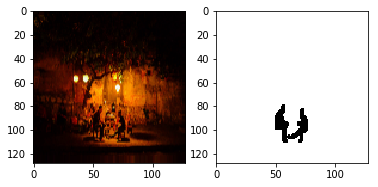

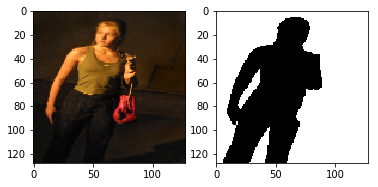

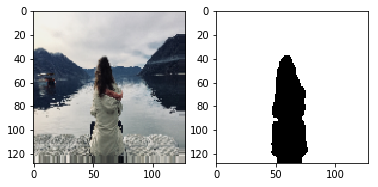

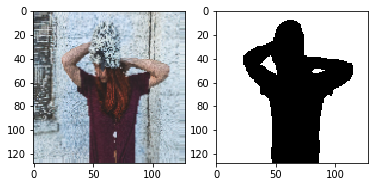

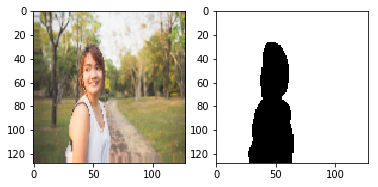

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
for _ in range(5):
    inp,otp = next(myGene)
    f, axarr = plt.subplots(1,2)
    axarr[0].imshow(inp[0,:,:,:])
    if NUM_CLASS>1:
        axarr[1].imshow(otp.argmax(axis=-1)[0,:,:], cmap='Greys',  interpolation='nearest')
    else:
        axarr[1].imshow(np.squeeze(otp[0]), cmap='Greys',  interpolation='nearest')

## Train Model

In [11]:
model.fit_generator(myGene,steps_per_epoch=2000,epochs=100,
                    validation_data=valGene, validation_steps=100,
                    callbacks=[model_checkpoint,lr_cb],
                    initial_epoch=0)

Epoch 1/50
Found 5711 images belonging to 1 classes.
Found 5711 images belonging to 1 classes.
Found 5711 images belonging to 1 classes.
Found 5711 images belonging to 1 classes.
2000/2000 [==============================] - 176s 88ms/step - loss: 1.3251 - acc: 0.7358 - iou_score: 0.1916 - val_loss: 1.2922 - val_acc: 0.7461 - val_iou_score: 0.1607

Epoch 00001: loss improved from inf to 1.32512, saving model to ../results/Models/GUnet/mobilenetv2_GUnet_BCE_ACC_IOU_divide_1_sigmoid_128_train_person.hdf5
Epoch 2/50
2000/2000 [==============================] - 169s 85ms/step - loss: 1.2347 - acc: 0.7522 - iou_score: 0.2338 - val_loss: 1.3449 - val_acc: 0.7290 - val_iou_score: 0.1316

Epoch 00002: loss improved from 1.32512 to 1.23473, saving model to ../results/Models/GUnet/mobilenetv2_GUnet_BCE_ACC_IOU_divide_1_sigmoid_128_train_person.hdf5
Epoch 3/50
2000/2000 [==============================] - 168s 84ms/step - loss: 1.2132 - acc: 0.7567 - iou_score: 0.2437 - val_loss: 1.2978 - val_acc: 

KeyboardInterrupt: 

## Test Model

In [12]:
import skimage
import glob
import os
import numpy as np
from keras.preprocessing import image
import cv2
path = "../data/raw/test"
fnames = sorted(glob.glob(os.path.join(path,"*.jpg")))
images = []
images_ = []
outs = []
for f in fnames:
    img = skimage.io.imread(f)
    img_ = np.expand_dims(cv2.resize(img,INPUT_SHAPE[:2]),axis=0)
    img_ = preprocess_input(img_, imgNorm=IMGNORM)
    images_.append(img_)
    images.append(img)
    

In [13]:
%%timeit
_ = model.predict(images_[0])

6.39 ms ± 574 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [14]:
%%time
for img_ in images_:
    #outs.append(np.squeeze(model.predict(img_)).argmax(axis=-1))
    outs.append(np.squeeze(model.predict(img_)))

CPU times: user 170 ms, sys: 7.59 ms, total: 177 ms
Wall time: 162 ms


/home/avantariml/.local/lib/python3.5/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


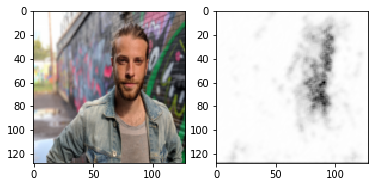

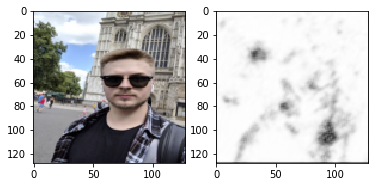

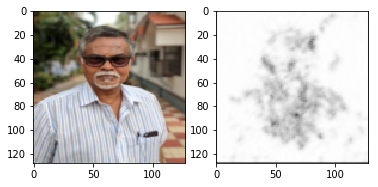

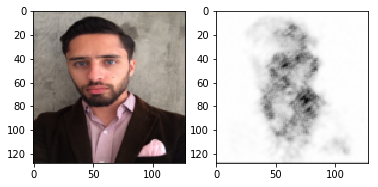

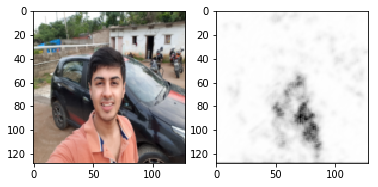

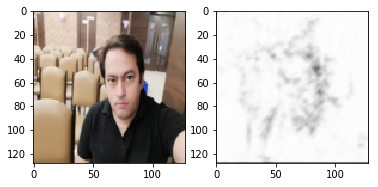

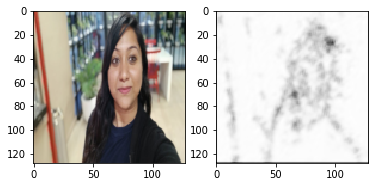

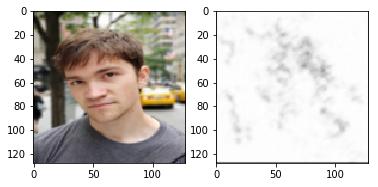

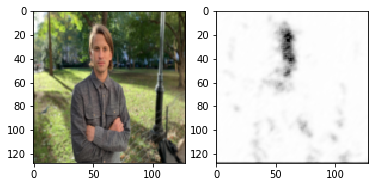

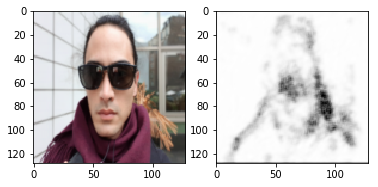

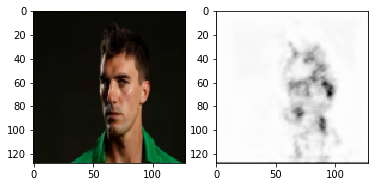

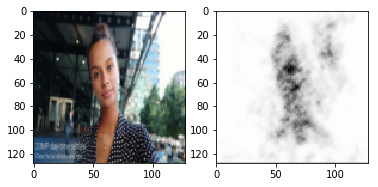

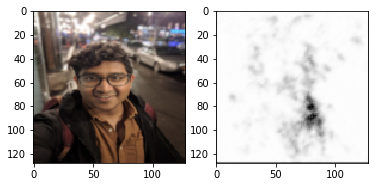

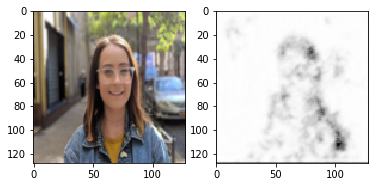

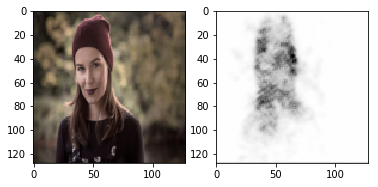

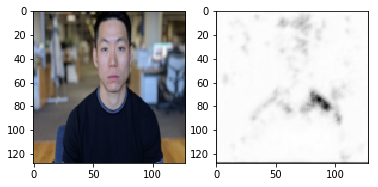

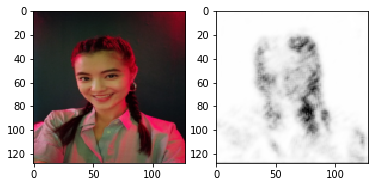

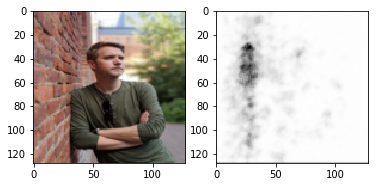

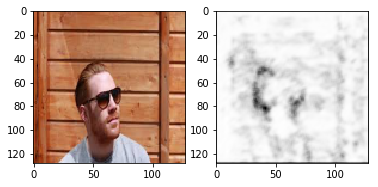

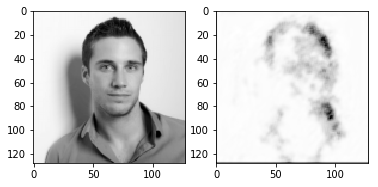

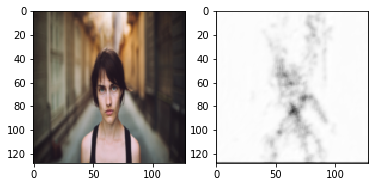

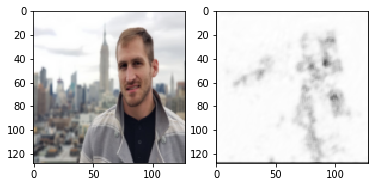

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline
for inp,otp in zip(images,outs):
    f, axarr = plt.subplots(1,2)
    axarr[0].imshow(skimage.transform.resize(inp,INPUT_SHAPE[:2],anti_aliasing=True))
    if NUM_CLASS>1:
        axarr[1].imshow(otp.argmax(axis=-1), cmap='Greys',  interpolation='nearest')
    else:
        axarr[1].imshow(otp*255, cmap='Greys',  interpolation='nearest')

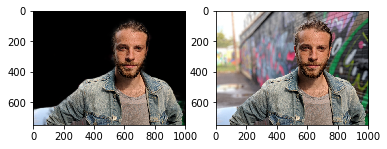

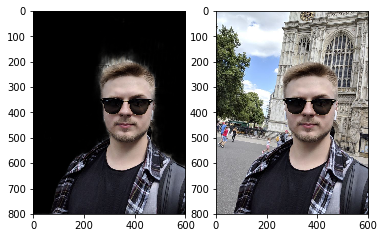

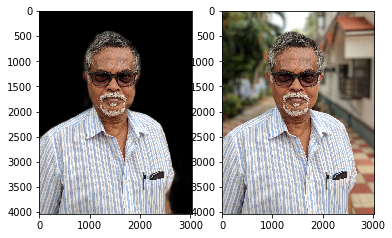

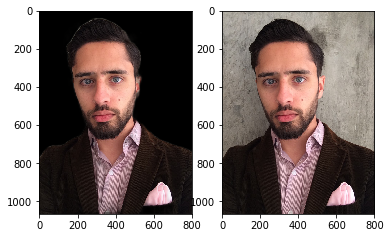

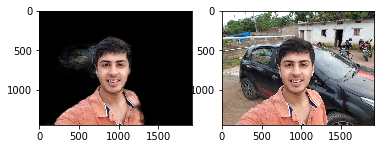

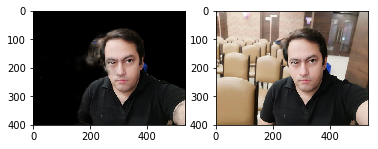

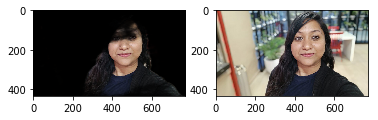

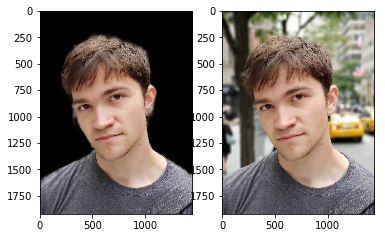

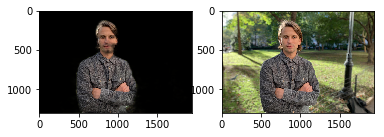

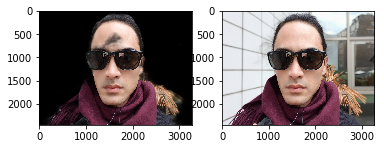

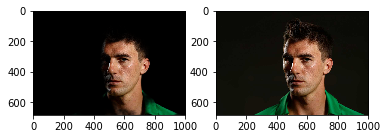

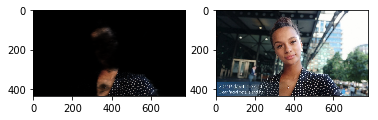

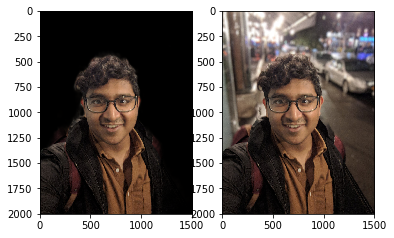

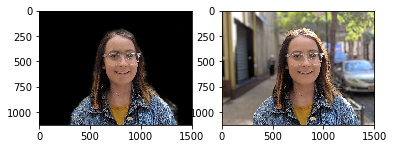

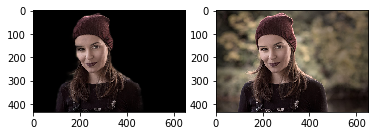

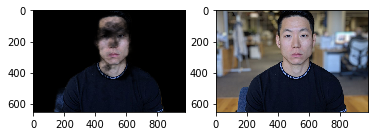

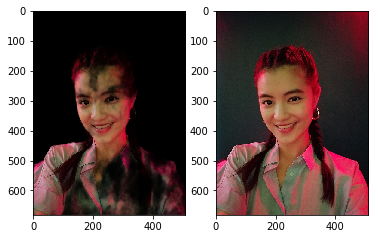

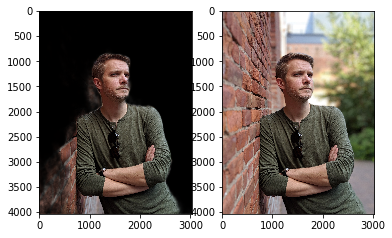

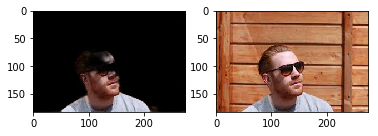

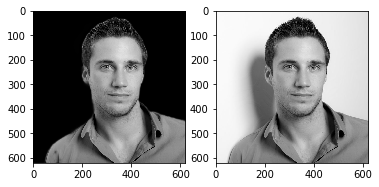

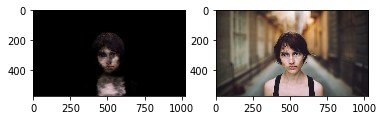

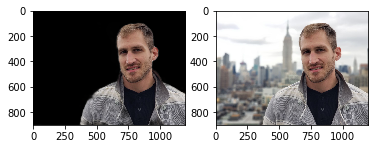

In [11]:
for inp,otp in zip(images,outs):
    mask = skimage.transform.resize(otp,inp.shape[:2],preserve_range=True)
    #mask = cv2.resize(otp,inp.shape[:2])
    im = np.copy(inp)
    #mask[mask>0.1]=1
    #im[mask==0]=0
    im = cv2.multiply(np.repeat(np.expand_dims(mask,axis=-1),3,axis=2).astype(float), im.astype(float))/255
    f, axarr = plt.subplots(1,2)
    axarr[0].imshow(im)
    axarr[1].imshow(inp)

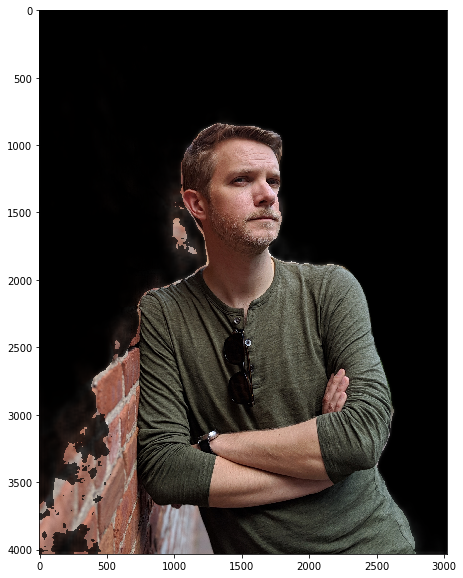

In [12]:
import random
i = random.choice(range(0,len(fnames)))
im = np.copy(images[i])
mask = skimage.transform.resize(outs[i],im.shape[:2],preserve_range=True)
mask[mask>0.3]=1
im = cv2.multiply(np.repeat(np.expand_dims(mask,axis=-1),3,axis=2).astype(float), im.astype(float))/255
#im[mask<0.3]=0
plt.rcParams['figure.figsize'] = [10,10]
plt.imshow(im)